# 0. 加载DNABERT模型

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model.eval()

def embeddings(dna):
    inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
    hidden_states = model(inputs)[0] # [1, sequence_length, 768]

    # embedding with mean pooling
    embedding_mean = torch.mean(hidden_states[0], dim=0).detach().numpy()
#     print(embedding_mean.shape) # expect to be 768

    # embedding with max pooling
#     embedding_max = torch.max(hidden_states[0], dim=0)[0].detach().numpy()
    return embedding_mean


dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
embeddings(dna).shape

# 0. 加载MEGADNA模型

In [ ]:
import torch
import numpy as np
model_path="/Volumes/PortableSSD/megaDNA_phage_145M.pt"
nucleotides = ['**', 'A', 'T', 'C', 'G', '#'] # vocabulary
mnucle = {'A':1,'T':2,'C':3,'G':4}
device = 'cpu' # use 'cuda' for GPU
megadna = torch.load(model_path, map_location=torch.device(device))
megadna.eval()

def embeddings(seq):
    encoded_sequence = np.array([0] +[ mnucle[c] for c in seq]+[5])
    input_seq = torch.tensor(encoded_sequence).unsqueeze(0).to(device) 
    output = megadna(input_seq, return_value = 'embedding')
    return output[0].reshape((1,-1)).detach().numpy()

def embedding_batch(seqs):
    encoded_sequence = np.array([np.array([0] +[ mnucle[c] for c in seq]+[5]) for seq in seqs])
    input_seq = torch.tensor(encoded_sequence).to(device) 
    output = megadna(input_seq, return_value = 'embedding')
    return output[0].reshape((len(seqs),-1)).detach().numpy()


seqs=["ATCCCGGGTGAGGCATCCCACCATCCTC",]
embeddings(seqs[0]).shape # (1, 1024)

# 1. 加载训练数据

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
import tqdm
df = pd.read_csv("/Users/john/Desktop/sev/DNA_RNA_DAY5.csv")
seq_len=118
df["seq"] =df["dna_seq"]
# df["seq"] = df["seq"].apply(lambda x:x[-seq_len:])
df["abs_score"] = df["rna_counts"]/df["plasmid_counts"]
df["score"] = np.log(df["abs_score"])
df["length"] = df["seq"].apply(lambda x:len(x))
df=df[(df["plasmid_counts"]>=30)]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_idx, test_idx in split.split(df, df["length"]):
    e_train = df.iloc[train_idx].reset_index(drop=True)
    e_test = df.iloc[test_idx].reset_index(drop=True)
print(e_train.shape, e_test.shape)

seq_e_test = np.concatenate([ embeddings(s) for s in tqdm.tqdm(e_test["seq"])])
seq_e_train = np.concatenate([ embeddings(s) for s in tqdm.tqdm(e_train["seq"])])
seq_e_test=seq_e_test.reshape((-1,768))
seq_e_train=seq_e_train.reshape((-1,768))

(2090, 9) (110, 9)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2090/2090 [07:24<00:00,  4.70it/s]


# 2. 构建DNN模型

In [13]:
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Dropout,Activation,InputLayer,BatchNormalization
import numpy as np
import tensorflow as tf
import random
import warnings


dim,UNITS,REG=768,128,1e-4
model = Sequential()
model.add(InputLayer(batch_input_shape=(None,dim)))
model.add(Dense(units=UNITS, kernel_initializer='glorot_normal',bias_initializer='zeros'))
# model.add(Dropout(0.3))
model.add(Dense(units=UNITS,kernel_initializer='glorot_normal',bias_initializer='zeros'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units=1))
model.add(Activation('linear'))
#compile the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss="mean_squared_error", optimizer=adam)
# model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,073 (449.50 KB)

 Trainable params: 115,073 (449.50 KB)

 Non-trainable params: 0 (0.00 B)

# 3. 训练DNN模型

In [14]:
import scipy.stats as stats
from sklearn import preprocessing
import tensorflow as tf
import os
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()
    
set_seed(42) 
col_label='score'
# Scale the training mean ribosome load values
e_test.loc[:,'scaled_rl'] =preprocessing.StandardScaler().fit_transform(e_test.loc[:,col_label].values.reshape(-1,1))
e_train.loc[:,'scaled_rl']=preprocessing.StandardScaler().fit_transform(e_train.loc[:,col_label].values.reshape(-1,1))
validation_data=(seq_e_test,e_test["scaled_rl"])
restore_best_weights=True
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min', 
                          verbose=1, restore_best_weights=True)
history = model.fit(seq_e_train, e_train['scaled_rl'], batch_size=64, epochs=15,callbacks=[earlyStop], 
                    verbose=1,validation_data=validation_data, shuffle=True)


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1024 - val_loss: 0.9834
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0147 - val_loss: 0.9754
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0016 - val_loss: 0.9687
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9872 - val_loss: 0.9602
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9722 - val_loss: 0.9591
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9628 - val_loss: 0.9613
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9622 - val_loss: 0.9602
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9517 - val_loss: 0.9624
Epoch 9/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9556 - val_loss: 0.9624
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9440 - val_loss: 0.9620
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


# 4. 评估模型效果

In [15]:
import scipy.stats as stats

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

e_test = test_data(df=e_test, model=model, obs_col=col_label,test_seq=seq_e_test)
r = r2(e_test[col_label], e_test['pred'])
pr =  stats.pearsonr(e_test[col_label], e_test['pred'])
print('test r-squared = ', r, "pearsonR = ", pr[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
test r-squared =  0.0299338973892717 pearsonR =  0.17301415372527104


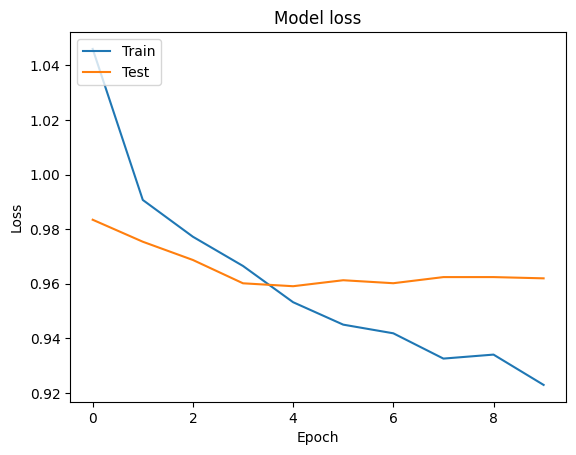

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()